In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Mon Nov 27 17:03:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 395 (delta 92), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (395/395), 108.50 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cuml
cuml.__version__

'23.10.00'

### Load Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/winequality-white.csv", delimiter=";")

data['quality'].value_counts().sort_index()

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64

### Group Wines where low amount of data is present (Manual)

In [ ]:
# Group the data by quality
data['quality'] = data['quality'].replace({3: 4, 9: 8}) # Group 3 with 4 and 9 with 8 (can be adjusted)

# Output the distribution of the quality after grouping
quality_distribution = data['quality'].value_counts().sort_index()
quality_distribution

4     183
5    1457
6    2198
7     880
8     180
Name: quality, dtype: int64

### Calculate Distance Matrix between Features (Everything except 'Quality')

In [ ]:
features = data.drop(columns='quality')

# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Calculate distance matrix
dist_matrix = distance_matrix(scaled_features, scaled_features)

# Lil test
dist_matrix.shape

(4898, 4898)

### Set parameters for Stratified Sampling

In [ ]:
sample_count = 180 # Number of samples to take from each quality
classes = [4, 5, 7, 8] # Which quality points to sample from
seed = 1 # For deterministic results
sampling_mode = 'min' # 'min' or 'max' for minimum or maximum distance sampling

## Stratified sampling based on distance between points in each quality group

In [ ]:
def stratified_sampling(dist_matrix, labels, num_samples, classes, seed, sampling_mode="min"):
    selected_indices = []

    # Remove randomness
    np.random.seed(seed)

    for label in classes:
        label_indices = np.where(labels == label)[0].tolist()

        # If less than num_samples, take all
        if len(label_indices) <= num_samples:
            selected_indices.extend(label_indices)
            continue

        # Take random sample
        current_index = np.random.choice(label_indices)
        selected_indices.append(current_index)

        for _ in range(num_samples - 1):
            # Select from remainder
            remaining_indices = list(set(label_indices) - set(selected_indices))
            distances = dist_matrix[current_index, remaining_indices]

            # Choose the next sample
            if sampling_mode == "min":
                current_index = remaining_indices[np.argmin(distances)]
            elif sampling_mode == "max":
                current_index = remaining_indices[np.argmax(distances)]
            else:
                raise ValueError("Invalid sampling_mode. Choose either 'min' or 'max'.")

            selected_indices.append(current_index)

    return selected_indices

# Extract indices of the stratified samples
selected_samples_indices = stratified_sampling(dist_matrix, data['quality'].values, sample_count, classes, seed, sampling_mode)

# Extract the rows corresponding to these indices
reduced_data = data.iloc[selected_samples_indices].reset_index(drop=True)
stratified_data_quality_distribution = reduced_data['quality'].value_counts().sort_index()

stratified_data_quality_distribution


4    180
5    180
7    180
8    180
Name: quality, dtype: int64

## Correlation Matrix

#### 1. R Style (somewhat)

In [ ]:
corr = reduced_data.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,0.10,0.37,0.11,0.10,-0.06,0.10,0.31,-0.51,0.00,-0.14,-0.17
volatile acidity,0.10,1.00,-0.20,-0.08,0.16,-0.17,-0.03,-0.03,-0.09,-0.02,0.08,-0.22
citric acid,0.37,-0.20,1.00,0.10,-0.07,-0.02,0.05,0.05,-0.13,0.10,0.14,0.13
residual sugar,0.11,-0.08,0.10,1.00,0.22,0.27,0.40,0.78,-0.17,-0.10,-0.43,-0.14
chlorides,0.10,0.16,-0.07,0.22,1.00,0.00,0.31,0.42,-0.07,0.09,-0.44,-0.32
free sulfur dioxide,-0.06,-0.17,-0.02,0.27,0.00,1.00,0.63,0.19,0.03,0.08,-0.12,0.11
total sulfur dioxide,0.10,-0.03,0.05,0.40,0.31,0.63,1.00,0.50,0.06,0.11,-0.38,-0.17
density,0.31,-0.03,0.05,0.78,0.42,0.19,0.50,1.00,-0.04,-0.01,-0.83,-0.49
pH,-0.51,-0.09,-0.13,-0.17,-0.07,0.03,0.06,-0.04,1.00,0.15,0.01,0.08
sulphates,0.00,-0.02,0.10,-0.10,0.09,0.08,0.11,-0.01,0.15,1.00,0.06,0.08


#### 2. Only one corner for easier reading

In [ ]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(color='#f1f1f1').format(precision=2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile acidity,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric acid,0.37,-0.20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual sugar,0.11,-0.08,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,0.10,0.16,-0.07,0.22,nan,nan,nan,nan,nan,nan,nan,nan
free sulfur dioxide,-0.06,-0.17,-0.02,0.27,0.00,nan,nan,nan,nan,nan,nan,nan
total sulfur dioxide,0.10,-0.03,0.05,0.40,0.31,0.63,nan,nan,nan,nan,nan,nan
density,0.31,-0.03,0.05,0.78,0.42,0.19,0.50,nan,nan,nan,nan,nan
pH,-0.51,-0.09,-0.13,-0.17,-0.07,0.03,0.06,-0.04,nan,nan,nan,nan
sulphates,0.00,-0.02,0.10,-0.10,0.09,0.08,0.11,-0.01,0.15,nan,nan,nan


#### 3. Using Seaborn library for styling

In [ ]:
corr = reduced_data.corr()
cm = sns.light_palette("green", as_cmap=True)
cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
corr.style.background_gradient(cmap=cm).format(precision=2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,0.10,0.37,0.11,0.10,-0.06,0.10,0.31,-0.51,0.00,-0.14,-0.17
volatile acidity,0.10,1.00,-0.20,-0.08,0.16,-0.17,-0.03,-0.03,-0.09,-0.02,0.08,-0.22
citric acid,0.37,-0.20,1.00,0.10,-0.07,-0.02,0.05,0.05,-0.13,0.10,0.14,0.13
residual sugar,0.11,-0.08,0.10,1.00,0.22,0.27,0.40,0.78,-0.17,-0.10,-0.43,-0.14
chlorides,0.10,0.16,-0.07,0.22,1.00,0.00,0.31,0.42,-0.07,0.09,-0.44,-0.32
free sulfur dioxide,-0.06,-0.17,-0.02,0.27,0.00,1.00,0.63,0.19,0.03,0.08,-0.12,0.11
total sulfur dioxide,0.10,-0.03,0.05,0.40,0.31,0.63,1.00,0.50,0.06,0.11,-0.38,-0.17
density,0.31,-0.03,0.05,0.78,0.42,0.19,0.50,1.00,-0.04,-0.01,-0.83,-0.49
pH,-0.51,-0.09,-0.13,-0.17,-0.07,0.03,0.06,-0.04,1.00,0.15,0.01,0.08
sulphates,0.00,-0.02,0.10,-0.10,0.09,0.08,0.11,-0.01,0.15,1.00,0.06,0.08


#### 4. Seaborn heatmap

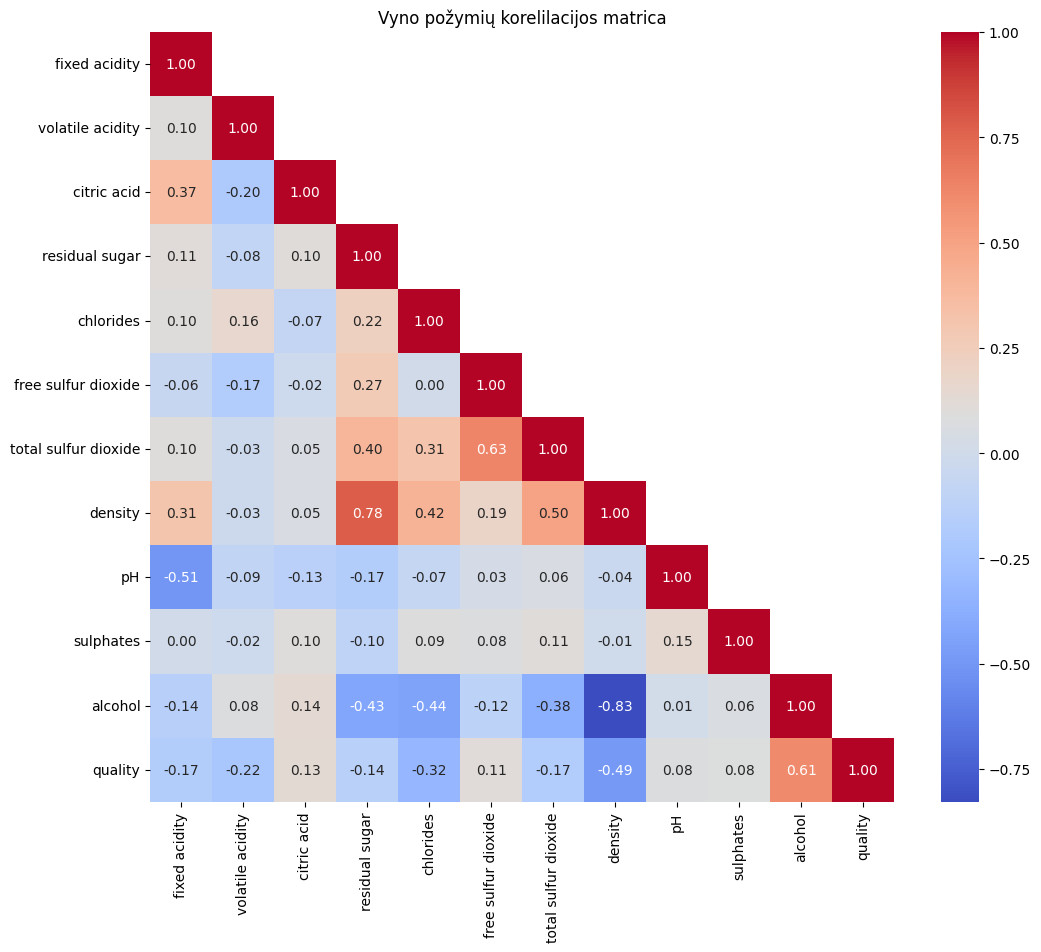

In [ ]:
corr = reduced_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Vyno požymių korelilacijos matrica")
plt.show()

## Descriptive Statistics

#### For whole dataset

In [ ]:
summary = reduced_data.describe()
summary = summary.transpose().round(2)
summary

,count,mean,std,min,25%,50%,75%,max
fixed acidity,720.0,6.80,0.88,3.90,6.20,6.70,7.20,11.80
volatile acidity,720.0,0.29,0.12,0.10,0.22,0.27,0.34,1.00
citric acid,720.0,0.30,0.11,0.00,0.26,0.30,0.36,0.88
residual sugar,720.0,5.62,4.55,0.70,1.70,4.40,8.00,18.30
chlorides,720.0,0.04,0.02,0.01,0.03,0.04,0.05,0.29
free sulfur dioxide,720.0,33.72,17.77,3.00,23.00,33.00,43.00,146.50
total sulfur dioxide,720.0,129.00,39.77,10.00,102.00,126.00,152.25,366.50
density,720.0,0.99,0.00,0.99,0.99,0.99,1.00,1.00
pH,720.0,3.22,0.14,2.83,3.13,3.22,3.31,3.72
sulphates,720.0,0.47,0.11,0.25,0.39,0.46,0.53,0.95


#### Based on wine quality rating

In [ ]:
for quality in sorted(reduced_data['quality'].unique()):
    print(f"\nQuality: {quality}")
    summary = reduced_data[reduced_data['quality'] == quality].describe()
    summary = summary.transpose().round(2)
    display(summary)


Quality: 4


,count,mean,std,min,25%,50%,75%,max
fixed acidity,180.0,7.20,1.18,4.20,6.40,6.90,7.75,11.80
volatile acidity,180.0,0.37,0.16,0.11,0.26,0.32,0.45,1.00
citric acid,180.0,0.31,0.16,0.00,0.21,0.30,0.40,0.88
residual sugar,180.0,4.85,4.35,0.70,1.38,2.70,7.60,17.55
chlorides,180.0,0.05,0.03,0.01,0.04,0.05,0.05,0.29
free sulfur dioxide,180.0,25.33,24.26,3.00,9.00,18.50,33.25,146.50
total sulfur dioxide,180.0,128.93,58.30,10.00,85.75,119.00,177.00,366.50
density,180.0,0.99,0.00,0.99,0.99,0.99,1.00,1.00
pH,180.0,3.18,0.17,2.83,3.06,3.16,3.28,3.72
sulphates,180.0,0.47,0.12,0.25,0.38,0.46,0.54,0.87



Quality: 5


,count,mean,std,min,25%,50%,75%,max
fixed acidity,180.0,6.62,0.61,5.30,6.20,6.60,7.02,8.10
volatile acidity,180.0,0.25,0.07,0.10,0.21,0.24,0.29,0.47
citric acid,180.0,0.26,0.09,0.01,0.21,0.27,0.33,0.49
residual sugar,180.0,8.76,5.09,0.90,5.28,7.90,12.32,18.30
chlorides,180.0,0.05,0.01,0.03,0.04,0.04,0.05,0.07
free sulfur dioxide,180.0,41.50,13.75,10.00,32.00,41.00,53.00,87.00
total sulfur dioxide,180.0,149.26,26.93,70.00,133.00,147.50,168.00,213.00
density,180.0,1.00,0.00,0.99,0.99,1.00,1.00,1.00
pH,180.0,3.24,0.11,3.02,3.17,3.22,3.30,3.63
sulphates,180.0,0.45,0.06,0.32,0.41,0.45,0.48,0.60



Quality: 7


,count,mean,std,min,25%,50%,75%,max
fixed acidity,180.0,6.70,0.69,5.40,6.20,6.60,7.10,9.20
volatile acidity,180.0,0.28,0.07,0.10,0.22,0.27,0.32,0.46
citric acid,180.0,0.31,0.05,0.14,0.28,0.30,0.34,0.49
residual sugar,180.0,3.22,1.98,0.90,1.60,2.55,4.75,10.20
chlorides,180.0,0.03,0.01,0.02,0.03,0.03,0.04,0.06
free sulfur dioxide,180.0,31.42,9.22,8.00,26.00,32.00,37.00,58.00
total sulfur dioxide,180.0,111.92,21.06,49.00,97.75,110.00,127.00,160.00
density,180.0,0.99,0.00,0.99,0.99,0.99,0.99,1.00
pH,180.0,3.23,0.14,2.93,3.15,3.25,3.32,3.59
sulphates,180.0,0.48,0.11,0.32,0.40,0.46,0.58,0.75



Quality: 8


,count,mean,std,min,25%,50%,75%,max
fixed acidity,180.0,6.68,0.83,3.90,6.20,6.80,7.30,9.10
volatile acidity,180.0,0.28,0.11,0.12,0.20,0.26,0.33,0.66
citric acid,180.0,0.33,0.09,0.04,0.28,0.32,0.36,0.74
residual sugar,180.0,5.63,4.25,0.80,2.08,4.30,8.15,14.80
chlorides,180.0,0.04,0.01,0.01,0.03,0.04,0.04,0.12
free sulfur dioxide,180.0,36.63,16.11,6.00,28.00,34.50,44.25,105.00
total sulfur dioxide,180.0,125.88,32.72,59.00,102.75,122.00,148.50,212.50
density,180.0,0.99,0.00,0.99,0.99,0.99,0.99,1.00
pH,180.0,3.22,0.15,2.94,3.13,3.23,3.33,3.59
sulphates,180.0,0.49,0.15,0.25,0.38,0.46,0.58,0.95


## Outlier Detection and Marking

### Outlier boxplots

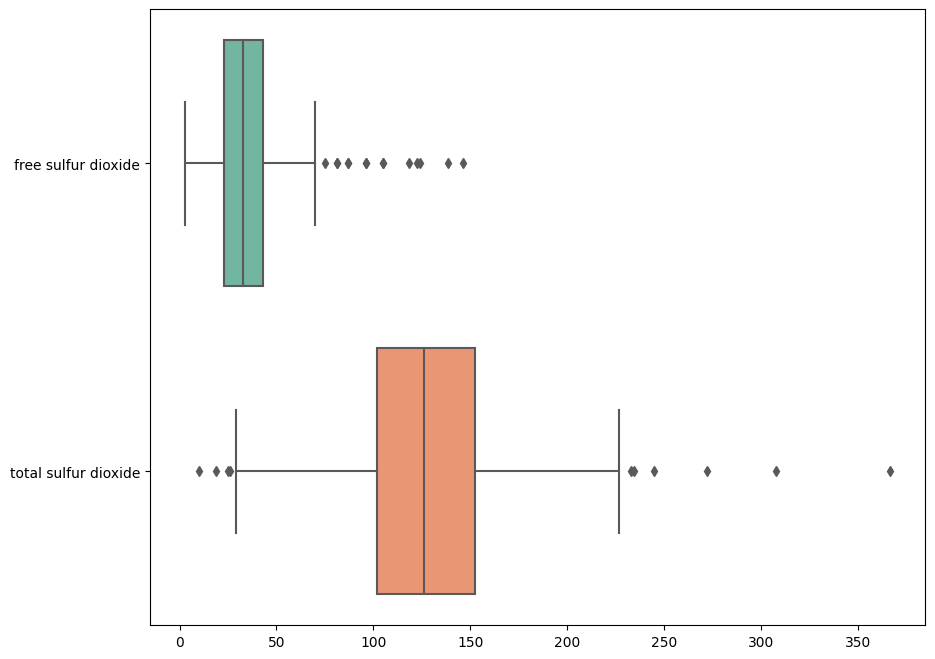

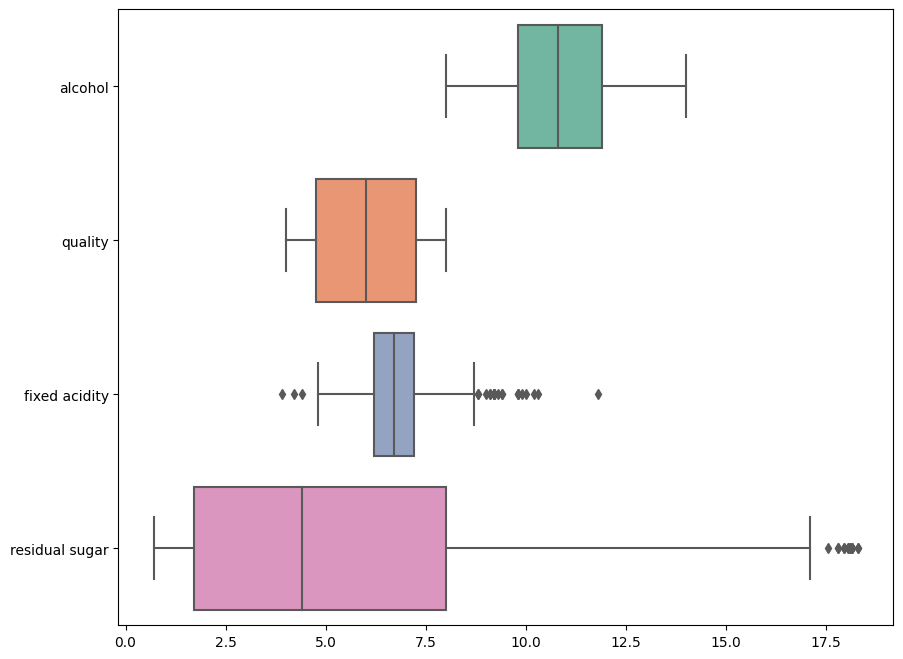

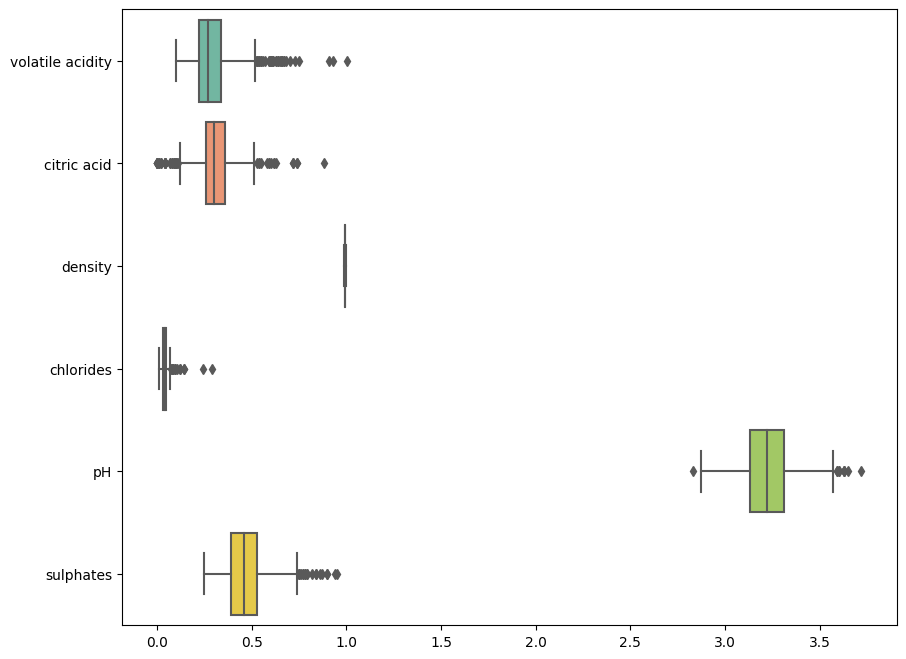

In [ ]:
def plot_boxplot(df, columns):
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df[columns], orient="h", palette="Set2")
    plt.show()

# Make a temporary copy of reduced_data
boxplot_data = reduced_data.copy()

# Boxplots
column_list = list(boxplot_data.columns)
chosen_columns = ['free sulfur dioxide', 'total sulfur dioxide']
if not chosen_columns:
    chosen_columns = list(boxplot_data.columns)
    plot_boxplot(boxplot_data, chosen_columns)
else:
    plot_boxplot(boxplot_data, chosen_columns)
    chosen_columns2 = ['alcohol', 'quality', 'fixed acidity', 'residual sugar']
    plot_boxplot(boxplot_data, chosen_columns2)
    column_list = list(set(column_list) - set(chosen_columns) - set(chosen_columns2))
    plot_boxplot(boxplot_data, column_list)

### Outlier marking and statistics

In [ ]:
def remove_outliers(df, columns):
    outlier_counts = {} # Dictionary to store outlier counts
    outlier_indices = pd.Index([]) # Empty index to store outliers
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        is_outlier = ~((df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR)))
        outlier_counts[column] = is_outlier.sum()  # Count outliers for the column
        outlier_indices = outlier_indices.union(df[is_outlier].index)

    # Remove outliers at once
    df_clean = df.drop(index=outlier_indices)
    return df_clean, outlier_counts, outlier_indices

clean_data = reduced_data.copy()

clean_data, outlier_counts, outlier_indices = remove_outliers(clean_data, list(clean_data.columns))

outlier_indices = reduced_data.index.difference(clean_data.index)
reduced_data['outlier'] = 0
reduced_data.loc[outlier_indices, 'outlier'] = 1

print(f"{'Column':<30} {'Count':<10} {'Percentage'}")
for column in clean_data.columns:
    count = outlier_counts.get(column, 0)
    percentage = (count / len(reduced_data)) * 100
    print(f"{column:<30} {count:<10} {percentage:.2f}%")

outlier_distribution = reduced_data['outlier'].value_counts()

display(outlier_distribution)

Column                         Count      Percentage
fixed acidity                  26         3.61%
volatile acidity               42         5.83%
citric acid                    48         6.67%
residual sugar                 15         2.08%
chlorides                      15         2.08%
free sulfur dioxide            14         1.94%
total sulfur dioxide           10         1.39%
density                        0          0.00%
pH                             10         1.39%
sulphates                      20         2.78%
alcohol                        0          0.00%
quality                        0          0.00%


0    559
1    161
Name: outlier, dtype: int64

### Outlier column check

In [ ]:
reduced_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,outlier
0,8.3,0.27,0.45,1.3,0.048,8.0,72.0,0.99440,3.08,0.61,10.3,4,0
1,8.2,0.26,0.44,1.3,0.046,7.0,69.0,0.99440,3.14,0.62,10.2,4,0
2,9.2,0.19,0.42,2.0,0.047,16.0,104.0,0.99517,3.09,0.66,10.0,4,1
3,9.4,0.29,0.55,2.2,0.050,17.0,119.0,0.99620,3.12,0.69,10.3,4,1
4,8.4,0.19,0.42,1.6,0.047,9.0,101.0,0.99400,3.06,0.65,11.1,4,0


### Drop outlier column (optional)

In [ ]:
# Drop the outlier column (if needed for smth)
reduced_data = reduced_data.drop(columns='outlier')

## Output to file (optional)

In [ ]:
reduced_data.to_csv('wines.csv', index=False, sep=';')

## Cartesian product

In [ ]:
df = pd.read_csv('wines.csv', delimiter=';')

df_pairplot = df.drop('outlier', axis=1)

df_features = df_pairplot.drop(columns='quality')
quality = df_pairplot['quality']

scaler = MinMaxScaler()

df_features_scaled = scaler.fit_transform(df_features)

df_features_scaled = pd.DataFrame(df_features_scaled, columns=df_features.columns)

df_features_scaled['quality'] = quality

pairplot = sns.pairplot(df_features_scaled, hue='quality', palette='viridis')

plt.legend(title='Quality', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

KeyboardInterrupt: ignored

## Change quality to binary, scale data and perform Train, Test, Val split

In [24]:
from sklearn.model_selection import train_test_split
wines_data = reduced_data.drop(['outlier'], axis=1)
wines_data['quality'] = wines_data['quality'].replace([4, 5], 0)
wines_data['quality'] = wines_data['quality'].replace([7, 8], 1)

features = wines_data.drop('quality', axis=1)
target = wines_data['quality']

X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=1, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=1, stratify=y_train_val)
# Training_Validation is 80% of the original data
# Training set is 70% of the training_validation data
# Validation set is 10% of the training_validation data
# Test set is 20% of the original data

# Data and what it represents
# X_train - training data
# X_val - validation data
# X_test - test data
# y_train - training target
# y_val - validation target
# y_test - test target

# Distribution of the target variable in different datasets
# Original amount of data
print("Original data distribution:")
display(target.value_counts())
print("Training set distribution:")
display(y_train.value_counts())
print("Validation set distribution:")
display(y_val.value_counts())
print("Test set distribution:")
display(y_test.value_counts())

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Retain appropriate index from original data for future outlier analysis
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)



Original data distribution:


0    360
1    360
Name: quality, dtype: int64

Training set distribution:


1    259
0    259
Name: quality, dtype: int64

Validation set distribution:


1    29
0    29
Name: quality, dtype: int64

Test set distribution:


1    72
0    72
Name: quality, dtype: int64

## SVM For Original Dataset

### Train SVM Classifier and Calculate Confusion Matrix and Metrics

Accuracy: 0.8275862068965517
Precision: 0.8518518518518519
Recall: 0.7931034482758621
F1 Score: 0.8214285714285715
Confusion matrix:
 [[25  4]
 [ 6 23]]


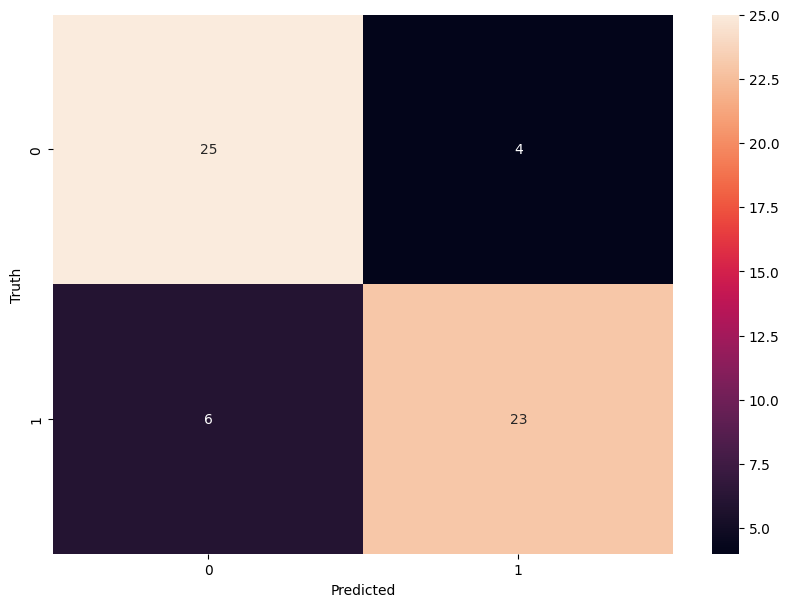

In [25]:
from cuml.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

svm = SVC()
svm.fit(X_train, y_train)

y_val_pred = svm.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_val, y_val_pred)
print(f"Precision: {precision}")

recall = recall_score(y_val, y_val_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_val, y_val_pred)
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_val, y_val_pred)

print("Confusion matrix:\n", cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()




### SVM data tuning

In [26]:
from cuml.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'degree': [2, 3],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1', verbose=3, refit=False)
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results[['param_C', 'param_gamma', 'param_degree', 'param_kernel', 'mean_test_score']].head()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END C=0.001, degree=2, gamma=scale, kernel=linear;, score=0.857 total time=   0.0s
[CV 2/5] END C=0.001, degree=2, gamma=scale, kernel=linear;, score=0.833 total time=   0.0s
[CV 3/5] END C=0.001, degree=2, gamma=scale, kernel=linear;, score=0.860 total time=   0.0s
[CV 4/5] END C=0.001, degree=2, gamma=scale, kernel=linear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.001, degree=2, gamma=scale, kernel=linear;, score=0.662 total time=   0.0s
[CV 1/5] END C=0.001, degree=2, gamma=scale, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/5] END C=0.001, degree=2, gamma=scale, kernel=rbf;, score=0.833 total time=   0.0s
[CV 3/5] END C=0.001, degree=2, gamma=scale, kernel=rbf;, score=0.860 total time=   0.0s
[CV 4/5] END C=0.001, degree=2, gamma=scale, kernel=rbf;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.001, degree=2, gamma=scale, kernel=rbf;, score=0.662 total time=   0.0s
[CV 1/5] END C=0.001, degree=2,

,param_C,param_gamma,param_degree,param_kernel,mean_test_score
182,1,10,2,poly,0.907369
181,1,10,2,rbf,0.907369
209,1,10,3,poly,0.907369
208,1,10,3,rbf,0.907369
207,1,10,3,linear,0.907369


### Refit the model with best parameters

In [27]:
# Based on the best parameters, try the top combinations. Results may vary
# best_model = SVC(C=1, kernel='rbf', gamma='scale', degree=2) # Best accuracy
best_model = SVC(C=1, kernel='rbf', gamma=10, degree=2) # Best F1 Metric
best_model.fit(X_train, y_train)


SVC()

### Calculate metrics for new model

Accuracy: 0.8448275862068966
Precision: 0.8846153846153846
Recall: 0.7931034482758621
F1 Score: 0.8363636363636363
Confusion matrix:
 [[26  3]
 [ 6 23]]


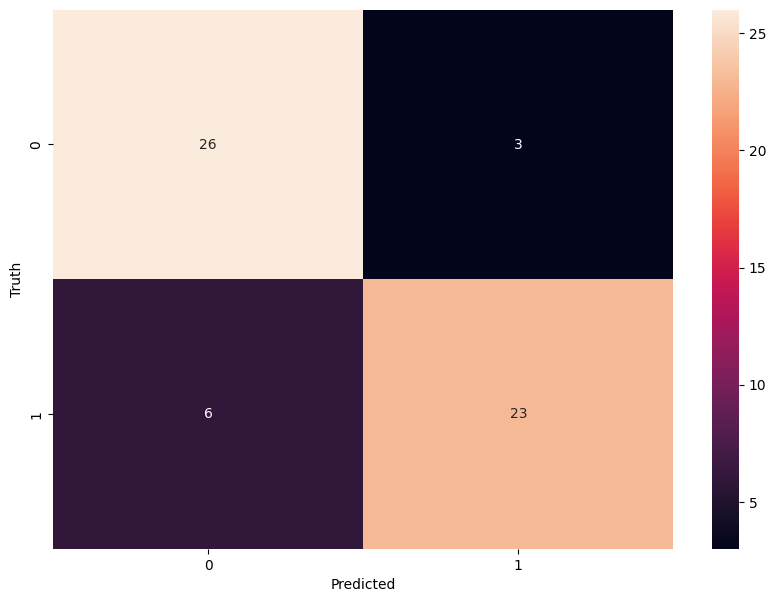

In [28]:
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_val, y_val_pred)
print(f"Precision: {precision}")

recall = recall_score(y_val, y_val_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_val, y_val_pred)
print(f"F1 Score: {f1}")

print("Confusion matrix:\n", cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Test data

Test Accuracy: 0.9375
Test Precision: 0.9701492537313433
Test Recall: 0.9027777777777778
Test F1 Score: 0.9352517985611511
Confusion matrix:
 [[70  2]
 [ 7 65]]


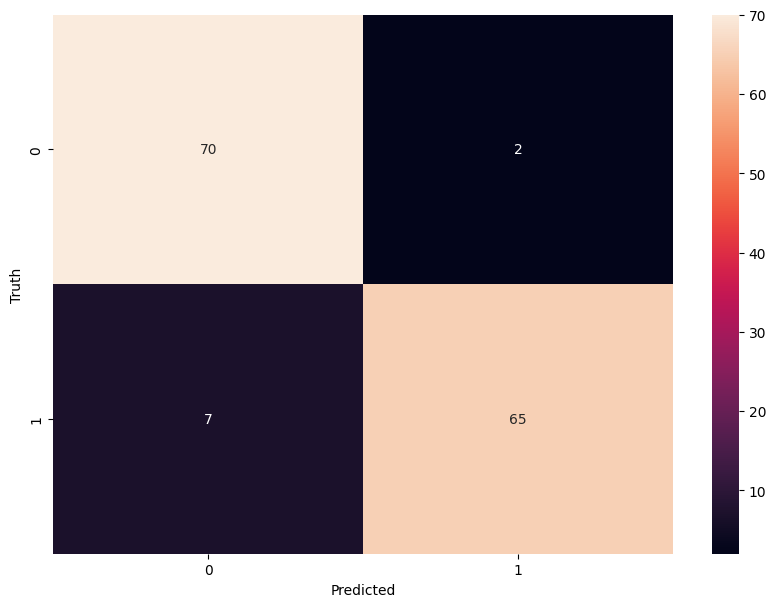

In [29]:
y_test_pred = best_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

cm_test = confusion_matrix(y_test, y_test_pred)

print("Confusion matrix:\n", cm_test)

plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Feature selection

##### Include outliers in results or not

In [30]:
include_outliers = True

### Fit features to PCA to find optimal number of features to keep

array([0.47265657, 0.68005074, 0.75986057, 0.81910256, 0.86578193,
       0.90543456, 0.94193702, 0.9707423 , 0.98347498, 0.99292232,
       0.9985016 , 1.        ])

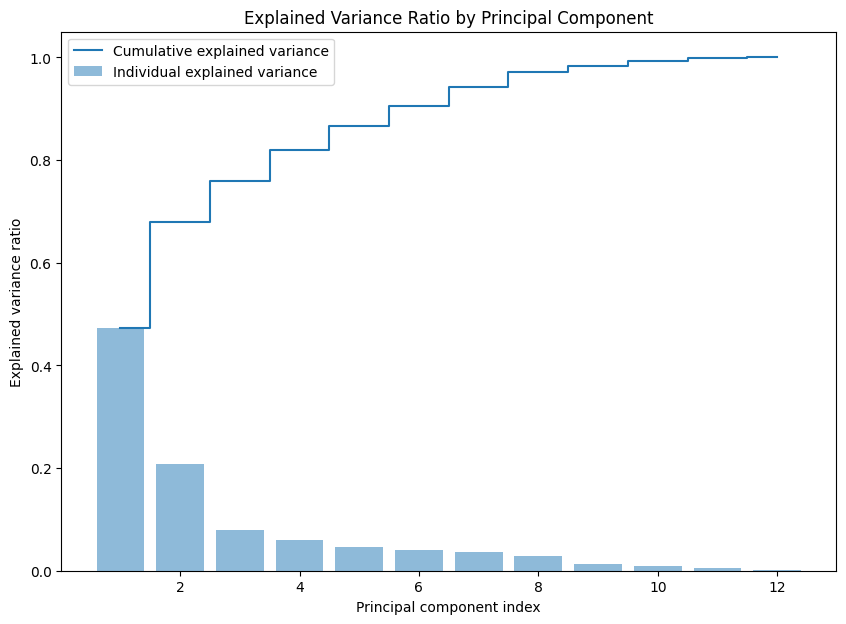

In [31]:
feature_selection_data = reduced_data.copy()

wine_features = feature_selection_data.copy()

if include_outliers:
        wine_features = wine_features.drop(columns=['outlier'])
else:
        feature_selection_data = feature_selection_data[feature_selection_data['outlier'] == 0]
        wine_features = wine_features[wine_features['outlier'] == 0].drop(columns=['outlier'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(wine_features)
scaled_wine_data = pd.DataFrame(scaled_features, columns=wine_features.columns)

pca = PCA()
pca.fit(scaled_wine_data)
explained_variance_ratio = pca.explained_variance_ratio_
display(explained_variance_ratio.cumsum())

# Plot the explained variance ratio for each principal component
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

### Fit and Transform selected number of components using PCA

In [32]:
# Select the number of components to keep based on the explained variance ratio (check results with +-1)
if include_outliers:
    n_components = 6
else:
    n_components = 7
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_wine_data)

### *Loadings* of PCA (Check for feature selection results)

In [33]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=scaled_wine_data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
fixed acidity,0.026159,0.009624,-0.057120,0.053544,-0.032444,-0.007096
volatile acidity,0.017632,-0.036056,-0.028632,0.003015,0.067056,0.014420
citric acid,-0.011398,0.023876,-0.028434,0.050972,-0.012231,-0.032606
residual sugar,0.121506,0.212396,-0.035914,-0.020386,0.064570,-0.013748
chlorides,0.027195,0.006271,0.005713,0.008204,-0.002454,0.001637
free sulfur dioxide,0.003559,0.050495,0.030368,0.011669,-0.003898,0.099186
total sulfur dioxide,0.039727,0.045400,0.029946,0.020210,0.001785,0.065489
density,0.167542,0.118079,0.020828,0.012863,-0.014595,-0.022722
pH,-0.017339,-0.014122,0.136528,-0.046480,0.035349,-0.031467
sulphates,-0.015431,-0.000561,0.072119,0.131238,0.033869,-0.015573


### PCA Reduction to two components

In [34]:
org_pca = PCA(n_components=2)
org_pca_result = org_pca.fit_transform(scaled_wine_data)

### Original Data Clustering using PCA

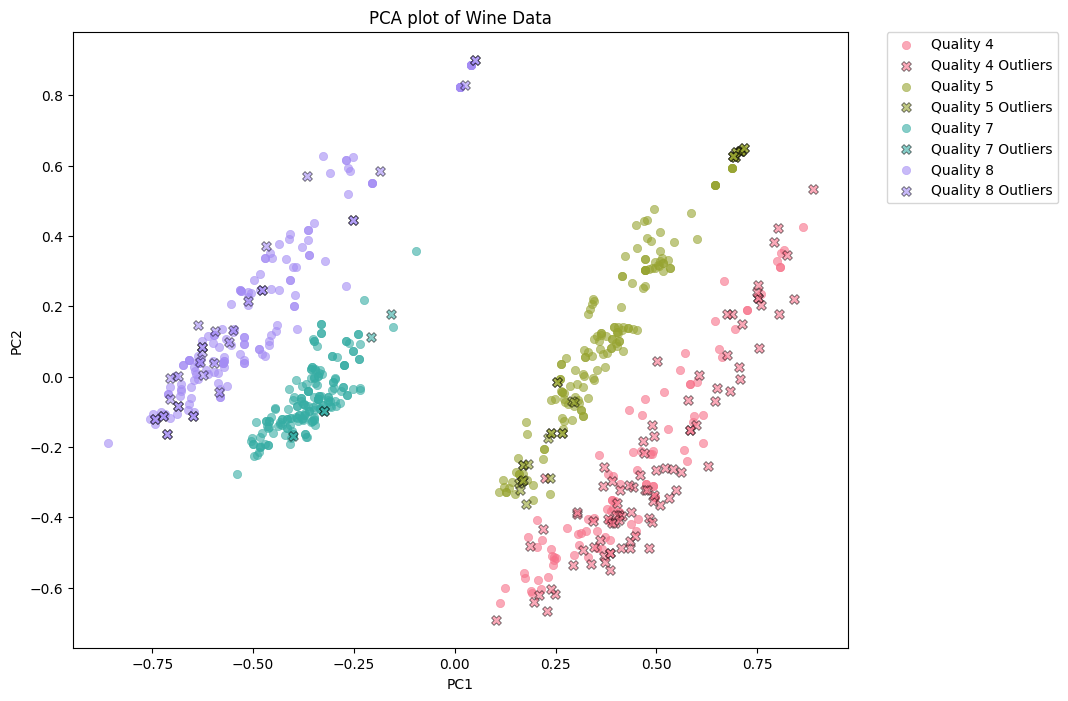

In [35]:
org_pca_result_df = pd.DataFrame({
    'PC1': org_pca_result[:, 0],
    'PC2': org_pca_result[:, 1],
    'Quality': feature_selection_data['quality'],
    'Outlier': feature_selection_data['outlier']
})

# Create a color palette with a unique color for each quality level (might be modified later)
palette = sns.color_palette("husl", len(org_pca_result_df['Quality'].unique()))
color_mapping = dict(zip(sorted(org_pca_result_df['Quality'].unique()), palette))

plt.figure(figsize=(10, 8))

# Plot non-outliers
for quality in org_pca_result_df['Quality'].unique():
    subset = org_pca_result_df[(org_pca_result_df['Quality'] == quality) & (org_pca_result_df['Outlier'] == 0)]
    sns.scatterplot(
        x="PC1", y="PC2",
        color=color_mapping[quality],
        data=subset,
        label=f'Quality {quality}',
        alpha=0.6,
        edgecolor=None
    )

# Plot outliers
    if include_outliers:
        outlier_subset = org_pca_result_df[(org_pca_result_df['Quality'] == quality) & (org_pca_result_df['Outlier'] == 1)]
        sns.scatterplot(
            x="PC1", y="PC2",
            color=color_mapping[quality],
            data=outlier_subset,
            label=f'Quality {quality} Outliers',
            alpha=0.6,
            marker='X',
            s=50,
            edgecolor='black'
        )

plt.title('PCA plot of Wine Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Apply t-SNE to the PCA-reduced data and plot the diagram

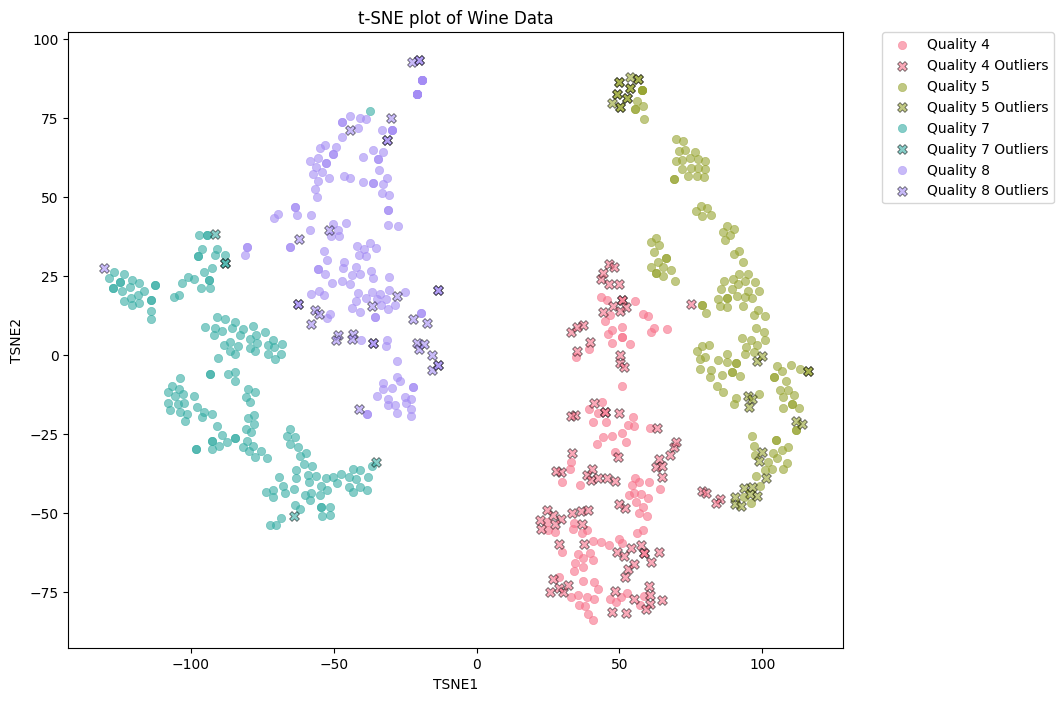

In [36]:
if include_outliers:
    # tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate="auto") # Default
    # tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=3000, learning_rate=10) # Pretty good
    # tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=3000, learning_rate=50) # Pretty good
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=3000, learning_rate=50) # Perfect circumstances for 7 components (2 clusters)
    # tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=3000, learning_rate=10) # Perfect circumstances for 5 components (Almost perfect clusters)
    # tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1000, learning_rate=50)  # Perfect circumstances for 5 components (Almost perfect clusters)
    # tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=3000, learning_rate=10)
else:
    # tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=5000, learning_rate=5, verbose=1) KL divergence 64 - 0.33
    # tsne = TSNE(n_components=2, random_state=42, perplexity=25, n_iter=5000, learning_rate=5) # Perfect circumstances for 6 components (2 clusters)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2000, learning_rate=80) # Perfect circumstances for 6 components (2 clusters)
tsne_result = tsne.fit_transform(pca_result)
# Create a DataFrame containing the t-SNE results
tsne_result_df = pd.DataFrame({
    'TSNE1': tsne_result[:, 0],
    'TSNE2': tsne_result[:, 1],
    'Quality': feature_selection_data['quality'],
    'Outlier': feature_selection_data['outlier']
})

# Create a color palette with a unique color for each quality level (might be modified later)
palette = sns.color_palette("husl", len(tsne_result_df['Quality'].unique()))
color_mapping = dict(zip(sorted(tsne_result_df['Quality'].unique()), palette))

plt.figure(figsize=(10, 8))

# Plot non-outliers
for quality in tsne_result_df['Quality'].unique():
    subset = tsne_result_df[(tsne_result_df['Quality'] == quality) & (tsne_result_df['Outlier'] == 0)]
    sns.scatterplot(
        x="TSNE1", y="TSNE2",
        color=color_mapping[quality],
        data=subset,
        label=f'Quality {quality}',
        alpha=0.6,
        edgecolor=None
    )

# Plot outliers
    if include_outliers:
        outlier_subset = tsne_result_df[(tsne_result_df['Quality'] == quality) & (tsne_result_df['Outlier'] == 1)]
        sns.scatterplot(
            x="TSNE1", y="TSNE2",
            color=color_mapping[quality],
            data=outlier_subset,
            label=f'Quality {quality} Outliers',
            alpha=0.6,
            marker='X',
            s=50,
            edgecolor='black'
        )

plt.title('t-SNE plot of Wine Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('tsne.png', dpi=300, bbox_inches='tight')
plt.show()

### Gaussian naive bayes

### Train Gaussian naive bayes Classifier and Calculate Confusion Matrix and Metrics

Validation Accuracy: 0.7758620689655172
Validation Precision: 0.7352941176470589
Validation Recall: 0.8620689655172413
Validation F1 Score: 0.7936507936507937
Confusion matrix (Validation):
 [[20  9]
 [ 4 25]]


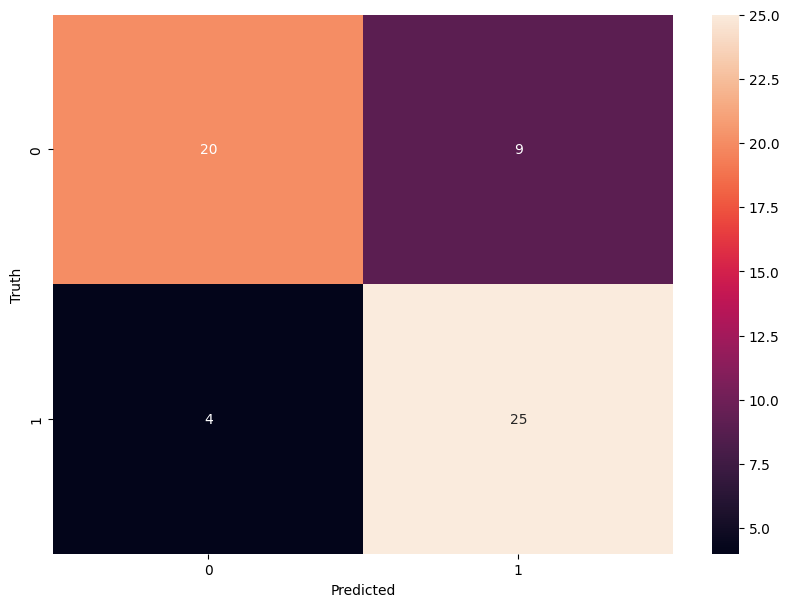

In [41]:
from cuml.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure data types are compatible
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)
X_val = np.array(X_val).astype(np.float32)
y_val = np.array(y_val).astype(np.int32)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier
gnb.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = gnb.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

# Display evaluation metrics for the validation set
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")

# Generate and display confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix (Validation):\n", cm_val)

plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Find best paramets for gaussian naive bayes

In [44]:
from cuml.naive_bayes import GaussianNB
from cuml.model_selection import GridSearchCV
import pandas as pd

# Assuming you have X_train, y_train as your data

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the parameter grid for the grid search
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
}

# Initialize the GridSearchCV with Gaussian Naive Bayes estimator
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='f1', verbose=3, refit=False)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Display the results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
top_results = results[['param_var_smoothing', 'mean_test_score']].head()
print(top_results)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.860 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.855 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.880 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.860 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.865 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.860 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.855 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.880 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.860 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.865 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.860 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

### Calculate metrics for new model vith best param var smoothing

Validation Accuracy: 0.7758620689655172
Validation Precision: 0.7352941176470589
Validation Recall: 0.8620689655172413
Validation F1 Score: 0.7936507936507937
Confusion matrix (Validation):
 [[20  9]
 [ 4 25]]


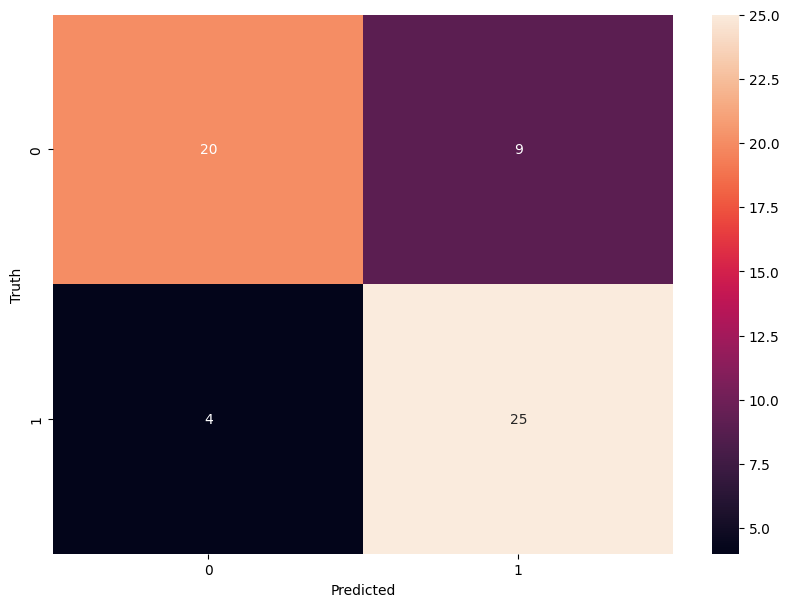

In [45]:
# Initialize the Gaussian Naive Bayes classifier with the best parameters
best_model = GaussianNB(var_smoothing=1e-9)
best_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

# Display evaluation metrics for the validation set
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")

# Generate and display confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix (Validation):\n", cm_val)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Test data

Test Accuracy: 0.8888888888888888
Test Precision: 0.868421052631579
Test Recall: 0.9166666666666666
Test F1 Score: 0.8918918918918918
Confusion matrix:
 [[62 10]
 [ 6 66]]


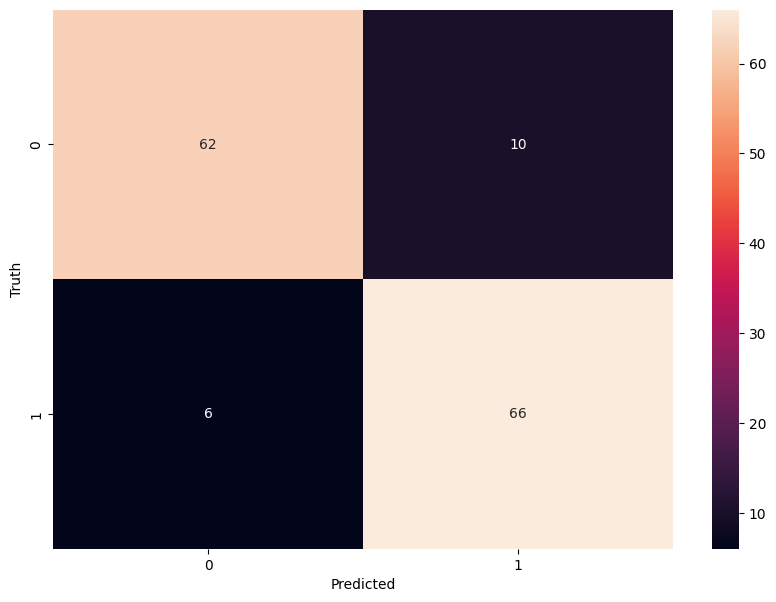

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Convert X_test to a NumPy array with float32 dtype
X_test_np = np.array(X_test).astype(np.float32)

# Convert y_test to a NumPy array with int32 dtype
y_test_np = np.array(y_test).astype(np.int32)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_np)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test_np, y_test_pred)
precision_test = precision_score(y_test_np, y_test_pred)
recall_test = recall_score(y_test_np, y_test_pred)
f1_test = f1_score(y_test_np, y_test_pred)

# Display evaluation metrics for the test set
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

# Generate and display confusion matrix for the test set
cm_test = confusion_matrix(y_test_np, y_test_pred)

print("Confusion matrix:\n", cm_test)

plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
